# Stock Price Prediction: Baseline Models Comparison

## Kapita Selekta - Kelompok 3

**Authors:**
- 2200018401 - Mohammad Farid Hendianto
- 2200018185 - Fidyah Rahman

---

## Abstract

This notebook implements four baseline deep learning models for stock price forecasting: **Convolutional Neural Network (CNN)**, **Long Short-Term Memory (LSTM)**, **Extended LSTM (xLSTM)**, and **Multilayer Perceptron (MLP)**. These models serve as benchmarks to evaluate the performance improvement achieved by the PatchTST architecture with Reversible Instance Normalization (RevIN).

## Methodology

### 1. Baseline Models

| Model | Architecture | Key Characteristics |
|-------|-------------|---------------------|
| **CNN** | 1D Convolutional layers with pooling | Captures local temporal patterns through sliding kernels |
| **LSTM** | Stacked LSTM layers with dropout | Models long-term dependencies via gating mechanisms |
| **xLSTM** | Extended LSTM with exponential gating | Enhanced memory capacity with exponential gates and layer normalization |
| **MLP** | Fully connected layers with ReLU | Simple feedforward baseline |

### 2. Experimental Setup

All models are trained under identical conditions:
- Same dataset (S&P 500 - AAPL)
- Same train/test split (80/20)
- Same feature set (12 technical indicators)
- Same loss function (MSE)
- Same evaluation metrics (RMSE, MAPE, Directional Accuracy)

---

## References

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural Computation*, 9(8), 1735-1780.

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. *Proceedings of the IEEE*, 86(11), 2278-2324.

Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. *Nature*, 323, 533-536.

Beck, M., Pöppel, K., Spanring, M., Auer, A., Prudnikova, O., Kopp, M., Klambauer, G., Brandstetter, J., & Hochreiter, S. (2024). xLSTM: Extended Long Short-Term Memory. *arXiv preprint arXiv:2405.04517*.

Nugent, C. (2018). *S&P 500 stock data* [Data set]. Kaggle. https://www.kaggle.com/datasets/camnugent/sandp500

## Section 1: Environment Setup

Initialize computational environment and configure reproducibility settings.

In [1]:
import sys

# Install required packages
%pip install --upgrade pip -q
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121 -q
%pip install pandas pandas_ta matplotlib seaborn -q

# Core libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import random
import os
import warnings
warnings.filterwarnings('ignore')

# Reproducibility Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 60)
print("ENVIRONMENT CONFIGURATION")
print("=" * 60)
print(f"Device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Random Seed: {SEED}")
print(f"PyTorch Version: {torch.__version__}")
print("=" * 60)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ENVIRONMENT CONFIGURATION
Device: cuda
CUDA Available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Random Seed: 42
PyTorch Version: 2.5.1+cu121


## Section 2: Feature Engineering

### Technical Indicator Selection

We use the same feature set as the PatchTST model for fair comparison:

| Category | Indicators | Purpose |
|----------|------------|---------|
| **Price-Based** | Log Returns, KAMA | Capture price momentum and adaptive trends |
| **Momentum** | RSI (7, 14), Stochastic, MACD, ROC | Identify overbought/oversold conditions |
| **Trend** | ADX | Measure trend strength |
| **Volatility** | ATR | Quantify market volatility |
| **Volume** | OBV | Track volume-price relationships |
| **Autoregressive** | Lagged Returns | Incorporate temporal dependencies |

In [2]:
# === CONFIGURATION PARAMETERS ===
DATA_PATH = 'dataset/sandp500/all_stocks_5yr.csv'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/dataset/sandp500/all_stocks_5yr.csv'

# Model hyperparameters
TICKER = 'AAPL'
LOOKBACK_WINDOW = 64
FORECAST_HORIZON = 5


def engineer_features(path: str, ticker: str) -> tuple:
    """
    Generate technical indicators for stock price prediction.
    
    Parameters
    ----------
    path : str
        Path to the CSV data file
    ticker : str
        Stock ticker symbol
        
    Returns
    -------
    tuple
        (DataFrame with features, list of feature column names)
    """
    print(f"[INFO] Processing data for {ticker}...")
    df_all = pd.read_csv(path)

    df_all.rename(columns={
        'date': 'Date', 'open': 'Open', 'high': 'High',
        'low': 'Low', 'close': 'Close', 'volume': 'Volume', 'name': 'Name'
    }, inplace=True)

    df = df_all[df_all['Name'] == ticker].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Technical indicators
    df.ta.kama(length=10, append=True)
    df.ta.adx(length=14, append=True)
    df.ta.rsi(length=14, append=True)
    df.ta.rsi(length=7, append=True)
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    df.ta.stoch(k=14, d=3, append=True)
    df.ta.roc(length=5, append=True)
    df.ta.atr(length=14, append=True)
    df.ta.obv(append=True)

    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    df['Log_Ret_Lag1'] = df['Log_Ret'].shift(1)
    df['Log_Ret_Lag2'] = df['Log_Ret'].shift(2)

    df.dropna(inplace=True)

    cols_to_use = [
        'Log_Ret', 'KAMA_10_2_30', 'RSI_14', 'RSI_7', 'ADX_14', 'ATRr_14',
        'MACD_12_26_9', 'MACDh_12_26_9', 'OBV', 'STOCHk_14_3_3', 'ROC_5',
        'Log_Ret_Lag1',
    ]

    final_cols = [c for c in cols_to_use if c in df.columns]
    print(f"[INFO] Generated {len(final_cols)} features")
    
    return df, final_cols


if os.path.exists(DATA_PATH):
    df, feature_cols = engineer_features(DATA_PATH, TICKER)
    print(f"[INFO] Selected Features ({len(feature_cols)}): {feature_cols}")
    print(f"[INFO] Dataset shape: {df.shape}")
    print(f"[INFO] Date range: {df['Date'].min()} to {df['Date'].max()}")
else:
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")


[INFO] Processing data for AAPL...
[INFO] Generated 12 features
[INFO] Selected Features (12): ['Log_Ret', 'KAMA_10_2_30', 'RSI_14', 'RSI_7', 'ADX_14', 'ATRr_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'OBV', 'STOCHk_14_3_3', 'ROC_5', 'Log_Ret_Lag1']
[INFO] Dataset shape: (1226, 26)
[INFO] Date range: 2013-03-28 00:00:00 to 2018-02-07 00:00:00


## Section 3: Dataset and DataLoader

Custom PyTorch Dataset with standard normalization for baseline models.


In [3]:
class FinancialDataset(Dataset):
    """
    PyTorch Dataset for financial time series forecasting.
    
    Applies standard normalization using training set statistics.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing feature columns
    lookback : int
        Number of historical days to use as input
    horizon : int
        Number of future days to predict
    feature_cols : list
        List of feature column names
    mean : np.ndarray, optional
        Feature means for normalization
    std : np.ndarray, optional
        Feature standard deviations for normalization
    """
    
    def __init__(self, data: pd.DataFrame, lookback: int, horizon: int, 
                 feature_cols: list, mean: np.ndarray = None, std: np.ndarray = None):
        self.lookback = lookback
        self.horizon = horizon
        self.X = data[feature_cols].values.astype(np.float32)
        self.target_idx = feature_cols.index('Log_Ret')
        
        # Store normalization parameters
        if mean is None:
            self.mean = self.X.mean(axis=0)
            self.std = self.X.std(axis=0) + 1e-8
        else:
            self.mean = mean
            self.std = std
        
        # Normalize features
        self.X_norm = (self.X - self.mean) / self.std

    def __len__(self) -> int:
        return len(self.X) - self.lookback - self.horizon + 1

    def __getitem__(self, idx: int) -> tuple:
        x = self.X_norm[idx : idx + self.lookback]
        y = self.X[idx + self.lookback : idx + self.lookback + self.horizon, self.target_idx]
        return x, y


# === DATA SPLITTING ===
TRAIN_RATIO = 0.80
train_size = int(len(df) * TRAIN_RATIO)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Create datasets with consistent normalization
train_set = FinancialDataset(train_df, LOOKBACK_WINDOW, FORECAST_HORIZON, feature_cols)
test_set = FinancialDataset(test_df, LOOKBACK_WINDOW, FORECAST_HORIZON, feature_cols,
                            mean=train_set.mean, std=train_set.std)

# DataLoader with reproducible shuffling
BATCH_SIZE = 32
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=g)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("=" * 60)
print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Training samples: {len(train_set)}")
print(f"Testing samples: {len(test_set)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")
print("=" * 60)


DATA SPLIT SUMMARY
Training samples: 912
Testing samples: 178
Batch size: 32
Training batches: 28
Testing batches: 6


## Section 4: Model Architectures

### 4.1 Convolutional Neural Network (CNN)

1D CNN architecture for time series:
- Three convolutional blocks with increasing filter sizes
- Batch normalization and ReLU activation
- Global average pooling followed by fully connected layers

### 4.2 Long Short-Term Memory (LSTM)

Stacked LSTM architecture:
- Two LSTM layers with hidden dimension 128
- Dropout for regularization
- Fully connected output layer

Reference: Hochreiter and Schmidhuber (1997) [1]

### 4.3 Extended LSTM (xLSTM)

Enhanced LSTM with exponential gating mechanism:
- Exponential input and forget gates for improved memory control
- Layer normalization for training stability
- Residual connections

Reference: Beck et al. (2024) [4]

### 4.4 Multilayer Perceptron (MLP)

Simple feedforward network:
- Flattened input
- Three hidden layers with ReLU activation
- Dropout regularization

In [4]:
class CNN1D(nn.Module):
    """
    1D Convolutional Neural Network for time series forecasting.
    
    Architecture:
    - Conv1D blocks with increasing channels (64 -> 128 -> 256)
    - Batch normalization and ReLU activation
    - Global average pooling
    - Two-layer prediction head
    
    Parameters
    ----------
    num_features : int
        Number of input features
    lookback : int
        Input sequence length
    horizon : int
        Prediction horizon
    """
    
    def __init__(self, num_features: int, lookback: int, horizon: int):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, horizon)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input: [B, T, C] -> [B, C, T]
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.squeeze(-1)
        out = self.head(x)
        return out


class LSTMModel(nn.Module):
    """
    Stacked LSTM for time series forecasting.
    
    Architecture:
    - Two-layer LSTM with hidden dimension 128
    - Dropout between layers
    - Fully connected prediction head
    
    Reference: Hochreiter and Schmidhuber (1997)
    
    Parameters
    ----------
    num_features : int
        Number of input features
    hidden_dim : int
        LSTM hidden dimension (default: 128)
    num_layers : int
        Number of LSTM layers (default: 2)
    horizon : int
        Prediction horizon
    """
    
    def __init__(self, num_features: int, hidden_dim: int = 128, 
                 num_layers: int = 2, horizon: int = 5):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, horizon)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input: [B, T, C]
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use last hidden state
        last_hidden = lstm_out[:, -1, :]
        out = self.head(last_hidden)
        return out


class xLSTMCell(nn.Module):
    """
    Extended LSTM Cell with exponential gating.
    
    Key innovations from Beck et al. (2024):
    - Exponential input gate for enhanced memory updates
    - Exponential forget gate for better long-term memory
    - Layer normalization for training stability
    
    Parameters
    ----------
    input_size : int
        Size of input features
    hidden_size : int
        Size of hidden state
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Combined linear for efficiency
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)
        
        # Layer normalization
        self.ln_cell = nn.LayerNorm(hidden_size)
        self.ln_hidden = nn.LayerNorm(hidden_size)
        
    def forward(self, x: torch.Tensor, states: tuple) -> tuple:
        h, c = states
        
        # Combined gates computation
        gates_ih = self.linear_ih(x)
        gates_hh = self.linear_hh(h)
        gates = gates_ih + gates_hh
        
        # Split into individual gates
        i, f, g, o = gates.chunk(4, dim=-1)
        
        # Exponential gating (key xLSTM innovation)
        i = torch.exp(torch.clamp(i, max=10))
        f = torch.exp(torch.clamp(f, max=10))
        
        # Normalize gates
        gate_sum = i + f + 1e-6
        i = i / gate_sum
        f = f / gate_sum
        
        # Cell state update
        g = torch.tanh(g)
        c_new = f * c + i * g
        c_new = self.ln_cell(c_new)
        
        # Output gate and hidden state
        o = torch.sigmoid(o)
        h_new = o * torch.tanh(c_new)
        h_new = self.ln_hidden(h_new)
        
        return h_new, c_new


class xLSTM(nn.Module):
    """
    Extended LSTM (xLSTM) for time series forecasting.
    
    Based on Beck et al. (2024) "xLSTM: Extended Long Short-Term Memory"
    
    Architecture:
    - xLSTM cells with exponential gating
    - Layer normalization
    - Residual connections between layers
    - Fully connected prediction head
    
    Reference: Beck et al. (2024) [4]
    
    Parameters
    ----------
    num_features : int
        Number of input features
    hidden_dim : int
        Hidden dimension (default: 128)
    num_layers : int
        Number of xLSTM layers (default: 2)
    horizon : int
        Prediction horizon
    dropout : float
        Dropout probability (default: 0.2)
    """
    
    def __init__(self, num_features: int, hidden_dim: int = 128, 
                 num_layers: int = 2, horizon: int = 5, dropout: float = 0.2):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Input projection
        self.input_proj = nn.Linear(num_features, hidden_dim)
        
        # xLSTM layers
        self.cells = nn.ModuleList([
            xLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers)
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Prediction head
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, horizon)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_proj(x)
        
        # Initialize hidden states
        h = [torch.zeros(batch_size, self.hidden_dim, device=x.device) 
             for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim, device=x.device) 
             for _ in range(self.num_layers)]
        
        # Process sequence
        for t in range(seq_len):
            inp = x[:, t, :]
            
            for layer_idx in range(self.num_layers):
                h[layer_idx], c[layer_idx] = self.cells[layer_idx](
                    inp, (h[layer_idx], c[layer_idx])
                )
                
                # Residual connection (skip first layer)
                if layer_idx > 0:
                    inp = inp + self.dropout(h[layer_idx])
                else:
                    inp = self.dropout(h[layer_idx])
        
        # Use final hidden state
        out = self.head(h[-1])
        return out


class MLP(nn.Module):
    """
    Multilayer Perceptron for time series forecasting.
    
    Architecture:
    - Flattened input
    - Three hidden layers (512 -> 256 -> 128)
    - ReLU activation and dropout
    
    Parameters
    ----------
    num_features : int
        Number of input features
    lookback : int
        Input sequence length
    horizon : int
        Prediction horizon
    """
    
    def __init__(self, num_features: int, lookback: int, horizon: int):
        super().__init__()
        
        input_dim = num_features * lookback
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, horizon)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# Model summary
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize models
models = {
    'CNN': CNN1D(len(feature_cols), LOOKBACK_WINDOW, FORECAST_HORIZON).to(device),
    'LSTM': LSTMModel(len(feature_cols), horizon=FORECAST_HORIZON).to(device),
    'xLSTM': xLSTM(len(feature_cols), horizon=FORECAST_HORIZON).to(device),
    'MLP': MLP(len(feature_cols), LOOKBACK_WINDOW, FORECAST_HORIZON).to(device)
}

print("=" * 60)
print("MODEL ARCHITECTURES")
print("=" * 60)
for name, model in models.items():
    params = count_parameters(model)
    print(f"{name}: {params:,} parameters")
print("=" * 60)


MODEL ARCHITECTURES
CNN: 160,069 parameters
LSTM: 213,381 parameters
xLSTM: 275,461 parameters
MLP: 558,597 parameters


## Section 5: Training Configuration

Training setup with MSE loss and Adam optimizer for fair comparison.


In [5]:
# Training configuration
EPOCHS = 100
PATIENCE = 15
LEARNING_RATE = 1e-3

criterion = nn.MSELoss()

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Loss Function: MSE")
print(f"Optimizer: Adam")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print("=" * 60)


TRAINING CONFIGURATION
Loss Function: MSE
Optimizer: Adam
Learning Rate: 0.001
Max Epochs: 100
Early Stopping Patience: 15


## Section 6: Model Training

Train all baseline models with identical conditions.

In [6]:
def train_model(model: nn.Module, model_name: str, train_loader: DataLoader, 
                test_loader: DataLoader, epochs: int, patience: int, lr: float) -> dict:
    """
    Train a model with early stopping.
    
    Parameters
    ----------
    model : nn.Module
        Model to train
    model_name : str
        Name for saving checkpoint
    train_loader : DataLoader
        Training data loader
    test_loader : DataLoader
        Validation data loader
    epochs : int
        Maximum number of epochs
    patience : int
        Early stopping patience
    lr : float
        Learning rate
        
    Returns
    -------
    dict
        Training history
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    best_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = criterion(pred, y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), f'baseline_{model_name.lower()}.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"   [STOP] Early stopping at Epoch {epoch+1}")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(f'baseline_{model_name.lower()}.pth', weights_only=True))
    history['best_val_loss'] = best_loss
    
    return history


# Train all models
results = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training {name}")
    print(f"{'='*70}")
    
    # Reset seed for reproducibility
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    # Reinitialize model
    if name == 'CNN':
        model = CNN1D(len(feature_cols), LOOKBACK_WINDOW, FORECAST_HORIZON).to(device)
    elif name == 'LSTM':
        model = LSTMModel(len(feature_cols), horizon=FORECAST_HORIZON).to(device)
    elif name == 'xLSTM':
        model = xLSTM(len(feature_cols), horizon=FORECAST_HORIZON).to(device)
    else:
        model = MLP(len(feature_cols), LOOKBACK_WINDOW, FORECAST_HORIZON).to(device)
    
    models[name] = model
    
    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, 
                              drop_last=True, generator=g)
    
    history = train_model(model, name, train_loader, test_loader, EPOCHS, PATIENCE, LEARNING_RATE)
    results[name] = history
    print(f"   [DONE] Best Val Loss: {history['best_val_loss']:.4f}")

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)



Training CNN
   Epoch 10 | Train: 2.1686 | Val: 2.1986
   [STOP] Early stopping at Epoch 16
   [DONE] Best Val Loss: 1.6433

Training LSTM
   Epoch 10 | Train: 2.1574 | Val: 1.8025
   [STOP] Early stopping at Epoch 19
   [DONE] Best Val Loss: 1.6350

Training xLSTM
   Epoch 10 | Train: 2.0289 | Val: 1.8917
   [STOP] Early stopping at Epoch 18
   [DONE] Best Val Loss: 1.6432

Training MLP
   Epoch 10 | Train: 1.8581 | Val: 1.8723
   [STOP] Early stopping at Epoch 17
   [DONE] Best Val Loss: 1.6350

TRAINING COMPLETE


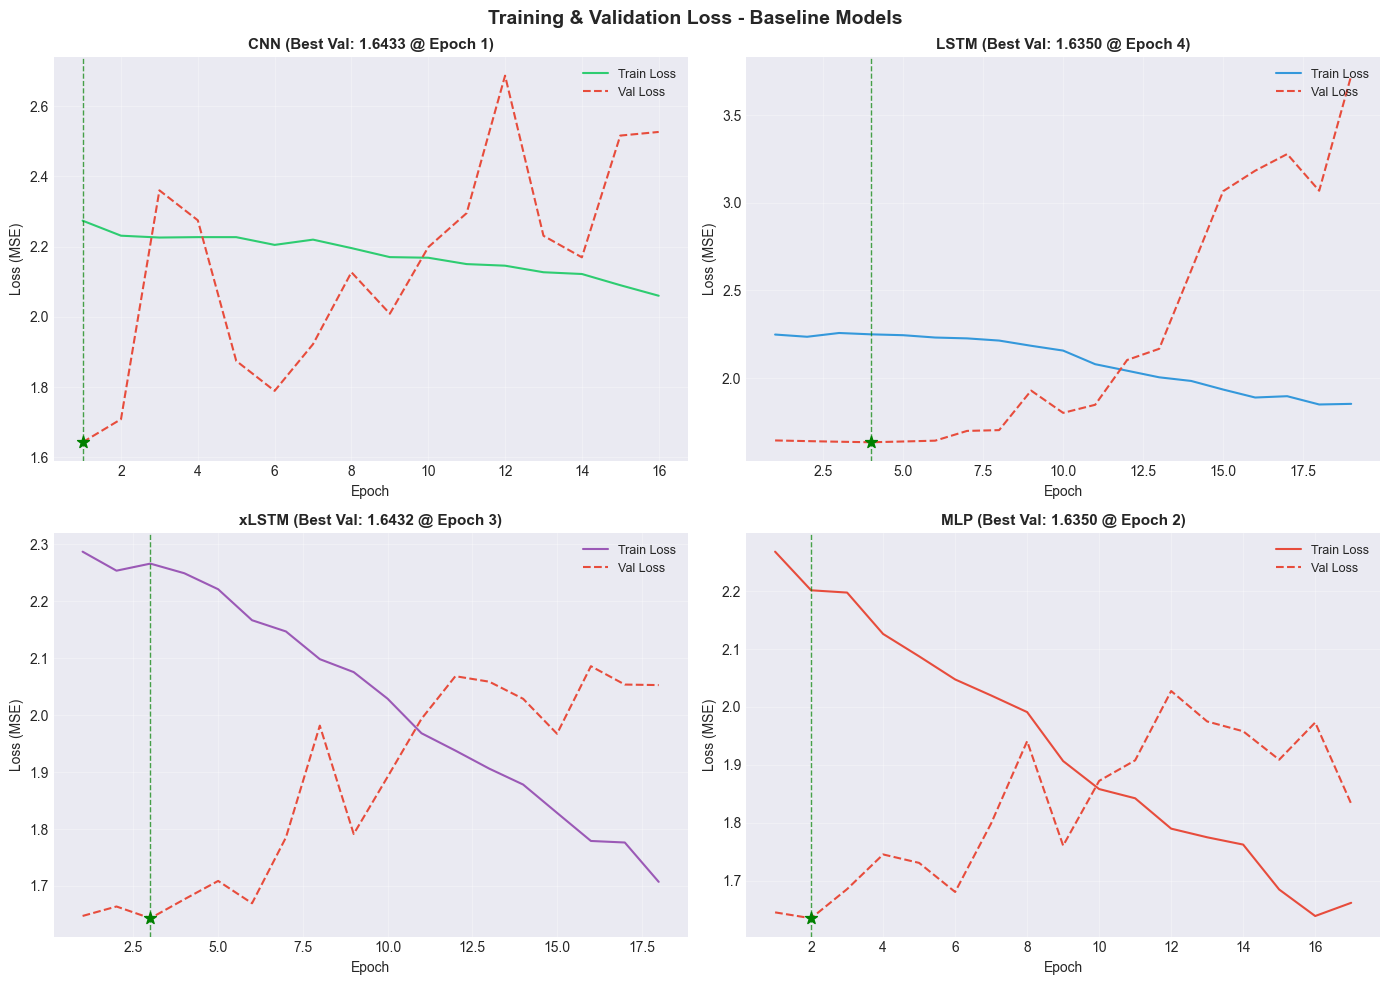


TRAINING SUMMARY
Model          Epochs   Best Val Loss   Final Train Loss
----------------------------------------------------------------------
CNN                16          1.6433             2.0604
LSTM               19          1.6350             1.8538
xLSTM              18          1.6432             1.7072
MLP                17          1.6350             1.6617
----------------------------------------------------------------------
Average          17.5          1.6391


In [7]:
# ============================================================
# TRAINING & VALIDATION LOSS VISUALIZATION
# ============================================================

# Create subplot for each baseline model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training & Validation Loss - Baseline Models', fontsize=14, fontweight='bold')

model_names_list = ['CNN', 'LSTM', 'xLSTM', 'MLP']
colors = {'CNN': '#2ecc71', 'LSTM': '#3498db', 'xLSTM': '#9b59b6', 'MLP': '#e74c3c'}

for idx, name in enumerate(model_names_list):
    ax = axes[idx // 2, idx % 2]
    history = results[name]
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot train and validation loss
    ax.plot(epochs, history['train_loss'], label='Train Loss', color=colors[name], linewidth=1.5)
    ax.plot(epochs, history['val_loss'], label='Val Loss', color='#e74c3c', linewidth=1.5, linestyle='--')
    
    # Mark best validation loss
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val = min(history['val_loss'])
    ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=1)
    ax.scatter([best_epoch], [best_val], color='green', s=80, zorder=5, marker='*')
    
    ax.set_title(f'{name} (Best Val: {best_val:.4f} @ Epoch {best_epoch})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\n" + "=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"{'Model':<10} {'Epochs':>10} {'Best Val Loss':>15} {'Final Train Loss':>18}")
print("-" * 70)
for name in model_names_list:
    history = results[name]
    best_val = min(history['val_loss'])
    num_epochs = len(history['train_loss'])
    final_train = history['train_loss'][-1]
    print(f"{name:<10} {num_epochs:>10} {best_val:>15.4f} {final_train:>18.4f}")
print("-" * 70)
avg_epochs = np.mean([len(results[n]['train_loss']) for n in model_names_list])
avg_val = np.mean([min(results[n]['val_loss']) for n in model_names_list])
print(f"{'Average':<10} {avg_epochs:>10.1f} {avg_val:>15.4f}")
print("=" * 70)

## Section 7: Evaluation

Evaluate all models on test set and compute metrics.


In [8]:
def evaluate_model_full_test(model: nn.Module, df: pd.DataFrame, feature_cols: list,
                              train_size: int, lookback: int, horizon: int,
                              train_mean: np.ndarray, train_std: np.ndarray) -> dict:
    """
    Evaluate model on FULL test set (20%) by using training data as initial lookback.
    This ensures predictions cover the entire test period, not just after lookback.
    
    Parameters
    ----------
    model : nn.Module
        Trained model
    df : pd.DataFrame
        Full dataframe with all data
    feature_cols : list
        List of feature columns
    train_size : int
        Size of training set
    lookback : int
        Lookback window size
    horizon : int
        Forecast horizon
    train_mean : np.ndarray
        Training data mean for normalization
    train_std : np.ndarray
        Training data std for normalization
        
    Returns
    -------
    dict
        Dictionary with predictions, actuals, and metrics
    """
    model.eval()
    
    # Get full data
    full_data = df[feature_cols].values.astype(np.float32)
    target_idx = feature_cols.index('Log_Ret')
    
    # Normalize using training statistics
    full_data_norm = (full_data - train_mean) / train_std
    
    all_preds = []
    all_actuals = []
    
    # Predict for EACH day in test set, using lookback that may include training data
    # Test period starts at train_size, ends at len(df)
    test_start = train_size
    test_end = len(df) - horizon + 1
    
    with torch.no_grad():
        for i in range(test_start, test_end):
            # Get lookback window (may include training data for early predictions)
            start_idx = i - lookback
            if start_idx < 0:
                continue
                
            x = full_data_norm[start_idx:i]
            y_actual = full_data[i:i + horizon, target_idx]
            
            # Predict
            x_tensor = torch.tensor(x).unsqueeze(0).to(device)
            pred = model(x_tensor).cpu().numpy()[0]
            
            all_preds.append(pred)
            all_actuals.append(y_actual)
    
    predictions = np.array(all_preds)
    actuals = np.array(all_actuals)
    
    # t+1 prediction
    pred_t1 = predictions[:, 0]
    act_t1 = actuals[:, 0]
    
    # Reconstruct price - now starting from train_size (beginning of test)
    ref_closes = df.iloc[train_size - 1 : train_size - 1 + len(predictions)]['Close'].values
    
    pred_price = ref_closes * np.exp(pred_t1 / 100)
    act_price = ref_closes * np.exp(act_t1 / 100)
    
    # Metrics
    rmse = np.sqrt(np.mean((act_price - pred_price) ** 2))
    mape = np.mean(np.abs((act_price - pred_price) / act_price)) * 100
    
    # Directional accuracy
    dir_correct = np.sum(np.sign(pred_t1) == np.sign(act_t1))
    dir_accuracy = dir_correct / len(pred_t1) * 100
    
    # R-squared
    ss_res = np.sum((act_price - pred_price) ** 2)
    ss_tot = np.sum((act_price - np.mean(act_price)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'pred_t1': pred_t1,
        'act_t1': act_t1,
        'pred_price': pred_price,
        'act_price': act_price,
        'rmse': rmse,
        'mape': mape,
        'dir_accuracy': dir_accuracy,
        'r2': r2,
        'num_predictions': len(predictions)
    }


# Get training statistics for normalization
train_data = df.iloc[:train_size][feature_cols].values.astype(np.float32)
train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0) + 1e-8

# Evaluate all models on FULL test set
evaluation_results = {}

print("\n" + "=" * 70)
print("EVALUATING ON FULL TEST SET (20%)")
print("=" * 70)

for name, model in models.items():
    eval_result = evaluate_model_full_test(
        model, df, feature_cols, train_size, 
        LOOKBACK_WINDOW, FORECAST_HORIZON, train_mean, train_std
    )
    evaluation_results[name] = eval_result
    print(f"[OK] {name}: {eval_result['num_predictions']} predictions")

# Print results table
print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)
print(f"{'Model':<10} {'RMSE':>12} {'MAPE (%)':>12} {'Dir.Acc (%)':>12} {'R-squared':>12}")
print("-" * 70)

for name in ['CNN', 'LSTM', 'xLSTM', 'MLP']:
    r = evaluation_results[name]
    print(f"{name:<10} {r['rmse']:>12.4f} {r['mape']:>12.4f} {r['dir_accuracy']:>12.2f} {r['r2']:>12.4f}")

print("=" * 70)



EVALUATING ON FULL TEST SET (20%)
[OK] CNN: 242 predictions
[OK] LSTM: 242 predictions
[OK] xLSTM: 242 predictions
[OK] MLP: 242 predictions

EVALUATION RESULTS
Model              RMSE     MAPE (%)  Dir.Acc (%)    R-squared
----------------------------------------------------------------------
CNN              1.7707       0.7915        52.07       0.9783
LSTM             1.7729       0.7913        53.31       0.9782
xLSTM            1.7841       0.7977        49.59       0.9779
MLP              1.8115       0.8223        48.76       0.9773


## Section 8: Visualization

Compare predictions and performance across all baseline models.

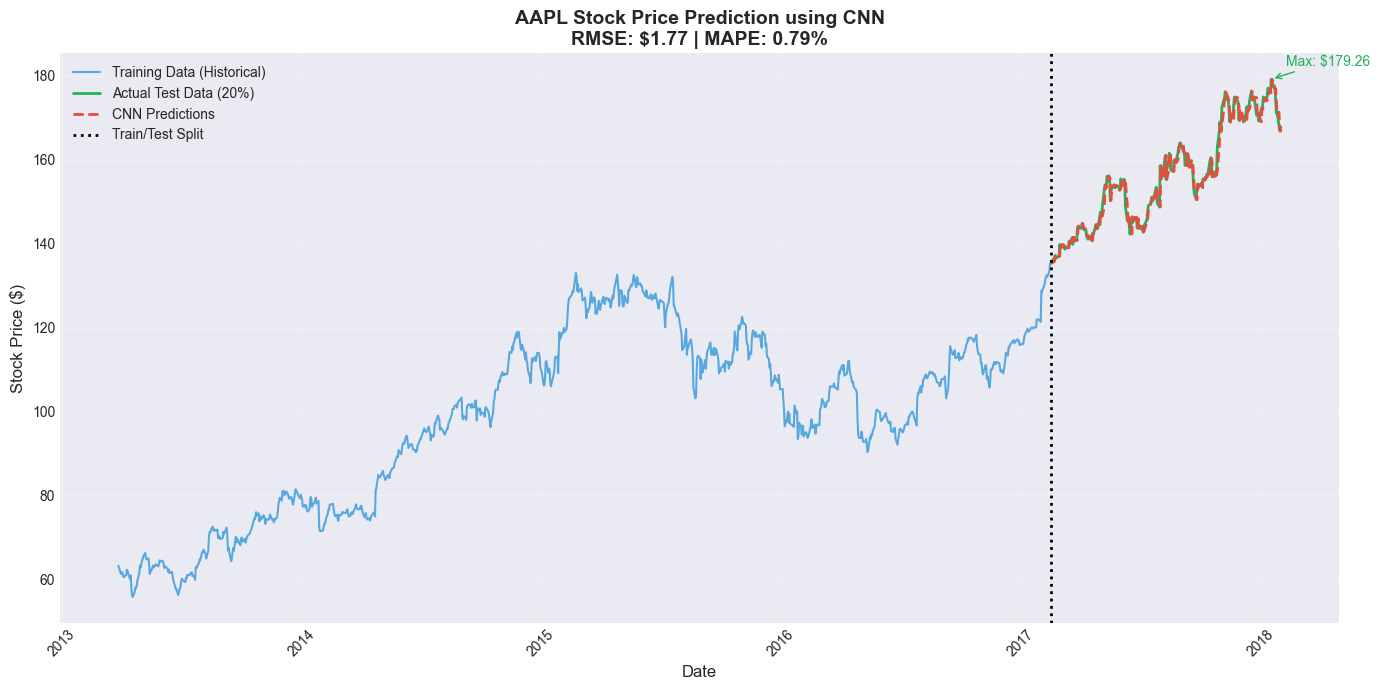


CNN - RMSE: $1.7707, MAPE: 0.7915%, Dir.Acc: 52.07%



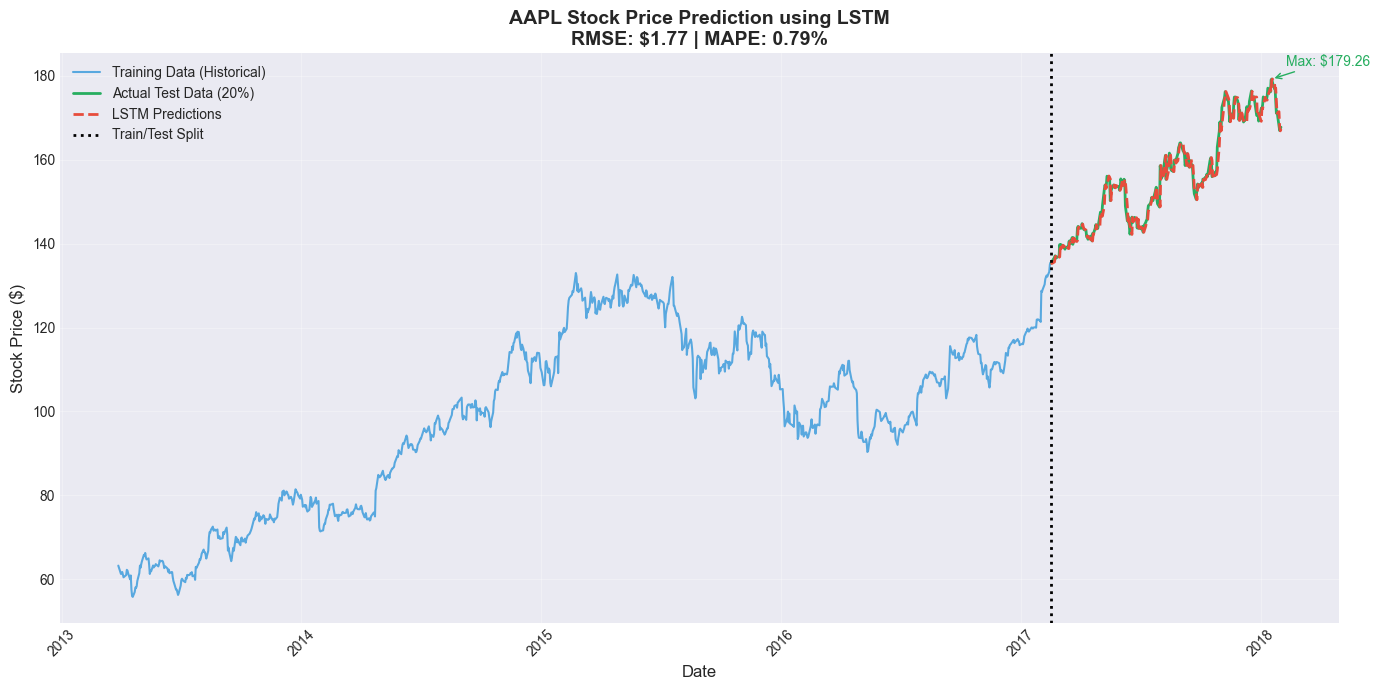


LSTM - RMSE: $1.7729, MAPE: 0.7913%, Dir.Acc: 53.31%



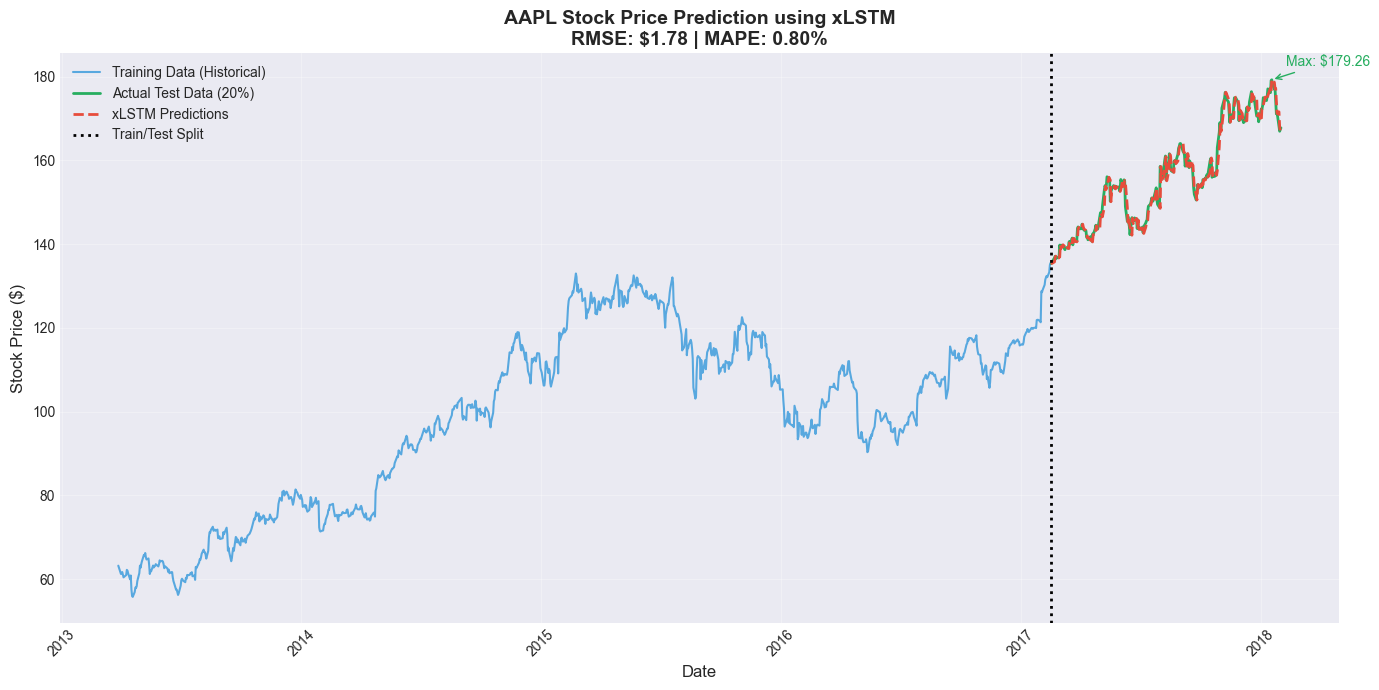


xLSTM - RMSE: $1.7841, MAPE: 0.7977%, Dir.Acc: 49.59%



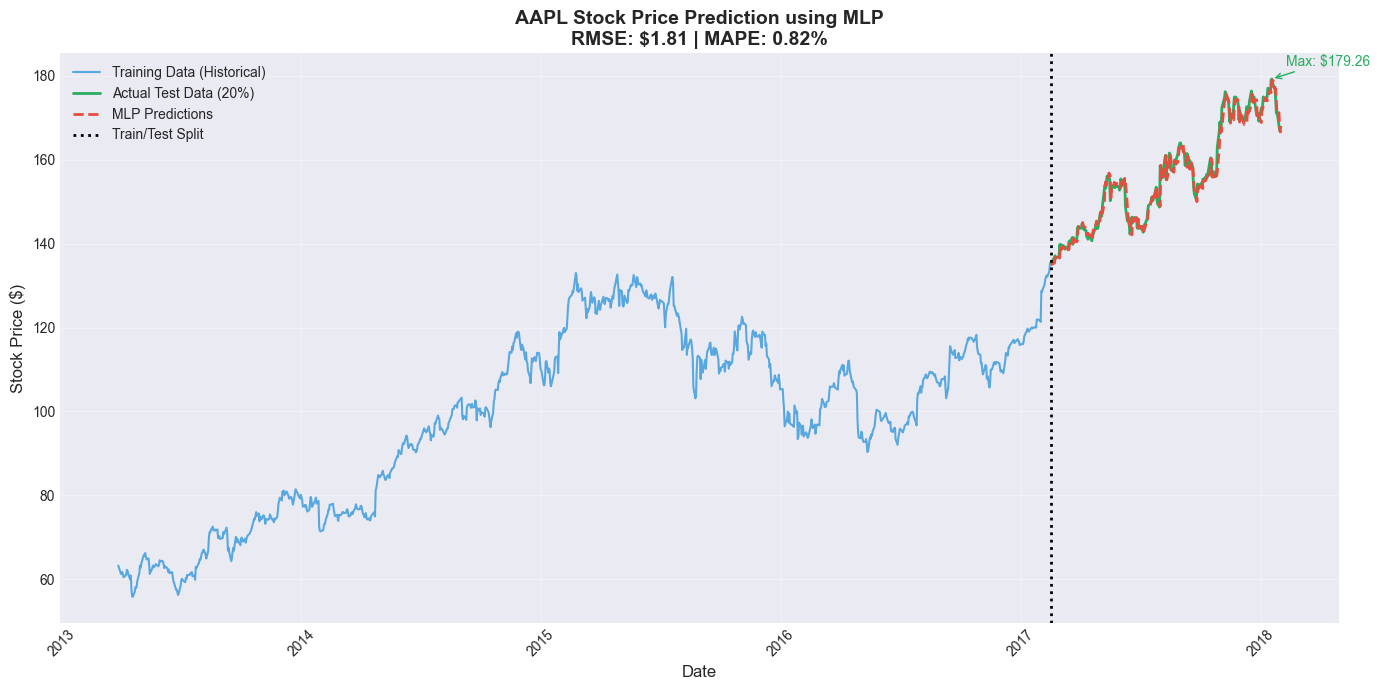


MLP - RMSE: $1.8115, MAPE: 0.8223%, Dir.Acc: 48.76%



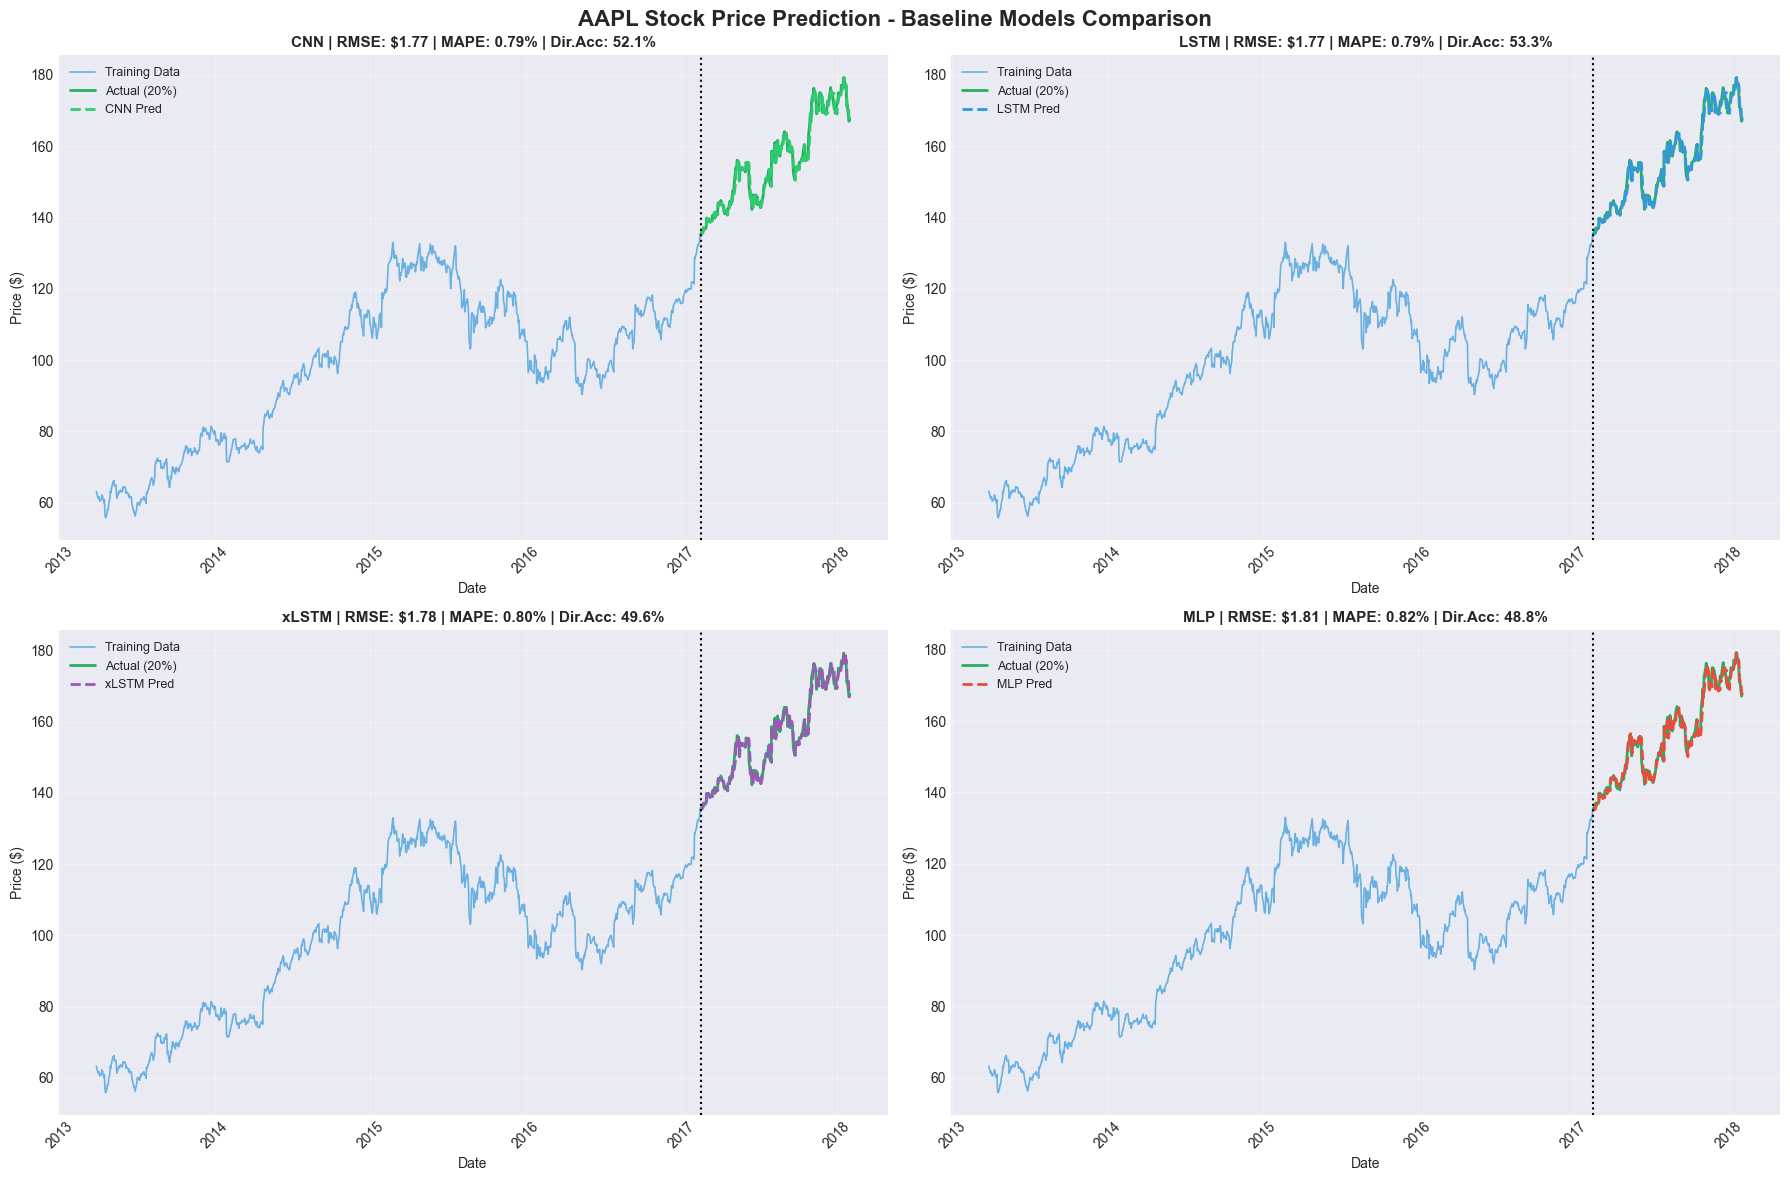

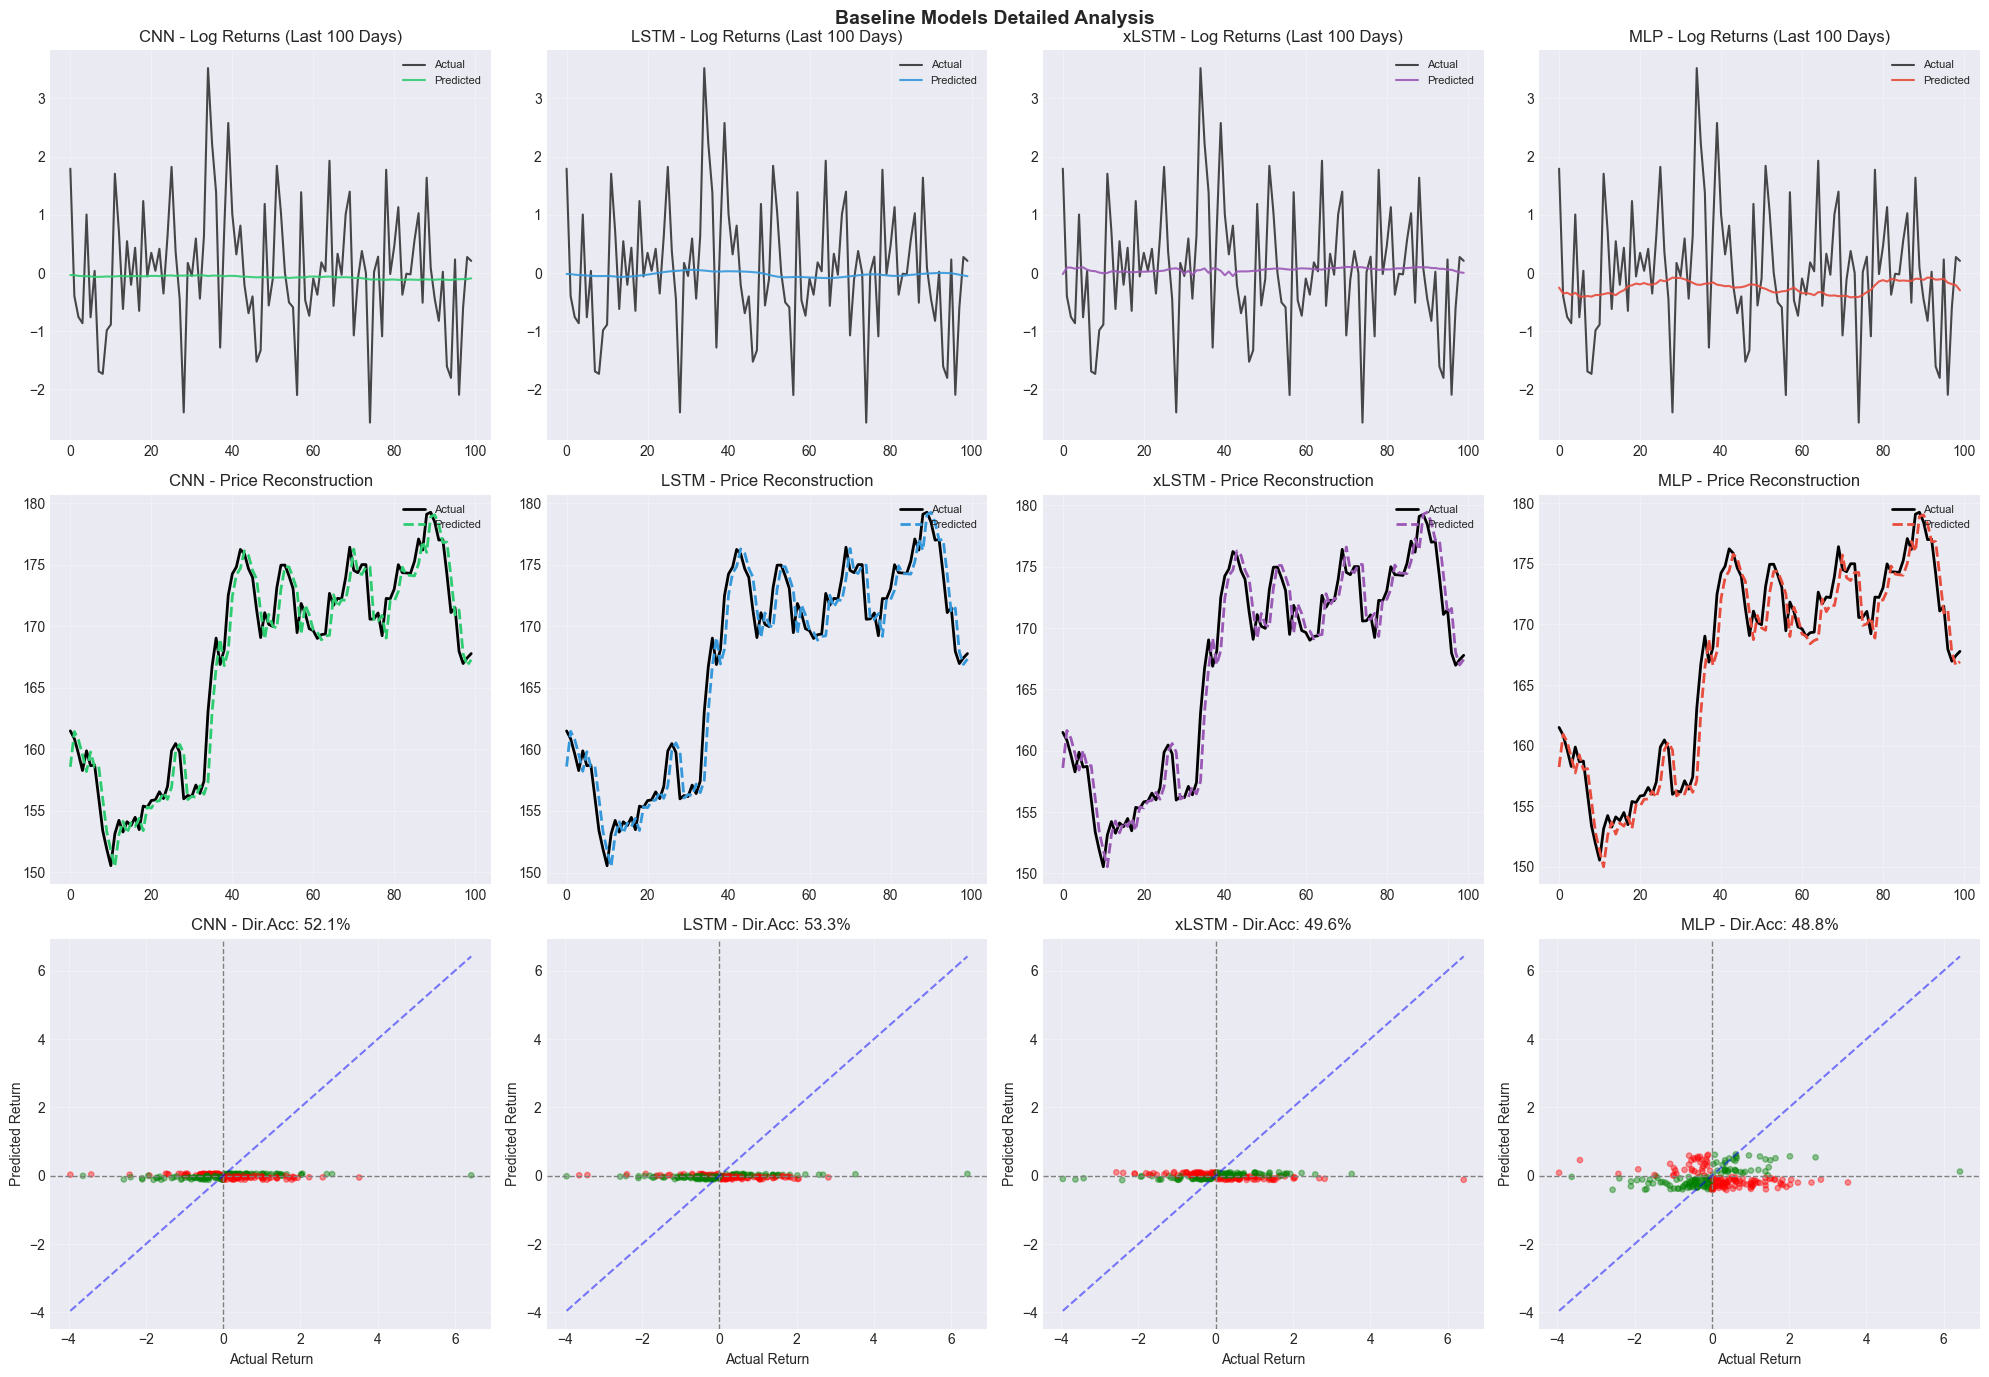

In [9]:
# ============================================================
# FULL STOCK PRICE PREDICTION CHART
# Now predictions cover the ENTIRE 20% test period!
# ============================================================

# Get full price history
all_dates = df['Date'].values
all_prices = df['Close'].values

# Split index (80% training, 20% test)
split_idx = train_size

# Prediction range - NOW STARTS FROM SPLIT POINT (full 20% test)
num_predictions = len(evaluation_results['LSTM']['pred_price'])
test_pred_dates = df.iloc[split_idx:split_idx + num_predictions]['Date'].values
test_actual_prices = df.iloc[split_idx:split_idx + num_predictions]['Close'].values

model_names = ['CNN', 'LSTM', 'xLSTM', 'MLP']
colors = {'CNN': '#2ecc71', 'LSTM': '#3498db', 'xLSTM': '#9b59b6', 'MLP': '#e74c3c'}

# Create individual charts for each model (like reference image)
for name in model_names:
    r = evaluation_results[name]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Title with metrics
    ax.set_title(f'AAPL Stock Price Prediction using {name}\nRMSE: ${r["rmse"]:.2f} | MAPE: {r["mape"]:.2f}%', 
                 fontsize=14, fontweight='bold')
    
    # Plot training data (historical) - 80% training
    ax.plot(all_dates[:split_idx], all_prices[:split_idx], color='#3498db', linewidth=1.5, 
            label='Training Data (Historical)', alpha=0.8)
    
    # Plot actual test data - FULL 20% test
    ax.plot(test_pred_dates, test_actual_prices, color='#27ae60', linewidth=2, 
            label='Actual Test Data (20%)')
    
    # Plot predictions - SAME RANGE as actual test (full 20%)
    ax.plot(test_pred_dates, r['pred_price'], color='#e74c3c', linewidth=2, 
            linestyle='--', label=f'{name} Predictions')
    
    # Train/Test split line
    split_date = df.iloc[split_idx]['Date']
    ax.axvline(x=split_date, color='black', linestyle=':', linewidth=2, 
               label='Train/Test Split')
    
    # Mark max price in test period
    max_price_idx = np.argmax(test_actual_prices)
    max_price = test_actual_prices[max_price_idx]
    max_date = test_pred_dates[max_price_idx]
    ax.annotate(f'Max: ${max_price:.2f}', xy=(max_date, max_price),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, color='#27ae60',
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1))
    
    # Labels and formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Stock Price ($)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    print(f"\n{name} - RMSE: ${r['rmse']:.4f}, MAPE: {r['mape']:.4f}%, Dir.Acc: {r['dir_accuracy']:.2f}%\n")


# ============================================================
# Combined comparison chart (all models in subplots)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('AAPL Stock Price Prediction - Baseline Models Comparison', fontsize=16, fontweight='bold')

for idx, name in enumerate(model_names):
    ax = axes[idx // 2, idx % 2]
    r = evaluation_results[name]
    
    # Plot training data (80%)
    ax.plot(all_dates[:split_idx], all_prices[:split_idx], color='#3498db', linewidth=1.2, 
            label='Training Data', alpha=0.7)
    
    # Plot actual test data (full 20%)
    ax.plot(test_pred_dates, test_actual_prices, color='#27ae60', linewidth=2, 
            label='Actual (20%)')
    
    # Plot predictions (full 20%)
    ax.plot(test_pred_dates, r['pred_price'], color=colors[name], linewidth=2, 
            linestyle='--', label=f'{name} Pred')
    
    # Train/Test split line
    ax.axvline(x=split_date, color='black', linestyle=':', linewidth=1.5)
    
    # Title with metrics
    ax.set_title(f'{name} | RMSE: ${r["rmse"]:.2f} | MAPE: {r["mape"]:.2f}% | Dir.Acc: {r["dir_accuracy"]:.1f}%', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# ============================================================
# Original detailed comparison (Log Returns, Price, Scatter)
# ============================================================
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
fig.suptitle('Baseline Models Detailed Analysis', fontsize=14, fontweight='bold')

for i, name in enumerate(model_names):
    r = evaluation_results[name]
    
    # Row 1: Log Returns
    ax = axes[0, i]
    ax.plot(r['act_t1'][-100:], label='Actual', alpha=0.7, color='black')
    ax.plot(r['pred_t1'][-100:], label='Predicted', alpha=0.9, color=colors[name])
    ax.set_title(f'{name} - Log Returns (Last 100 Days)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Row 2: Price Forecast
    ax = axes[1, i]
    ax.plot(r['act_price'][-100:], label='Actual', color='black', linewidth=2)
    ax.plot(r['pred_price'][-100:], label='Predicted', color=colors[name], 
            linestyle='--', linewidth=2)
    ax.set_title(f'{name} - Price Reconstruction')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Row 3: Scatter Plot
    ax = axes[2, i]
    scatter_colors = ['green' if (a > 0 and p > 0) or (a < 0 and p < 0) else 'red' 
                      for a, p in zip(r['act_t1'], r['pred_t1'])]
    ax.scatter(r['act_t1'], r['pred_t1'], c=scatter_colors, alpha=0.4, s=15)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    lims = [min(r['act_t1'].min(), r['pred_t1'].min()), 
            max(r['act_t1'].max(), r['pred_t1'].max())]
    ax.plot(lims, lims, 'b--', alpha=0.5)
    ax.set_xlabel('Actual Return')
    ax.set_ylabel('Predicted Return')
    ax.set_title(f'{name} - Dir.Acc: {r["dir_accuracy"]:.1f}%')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


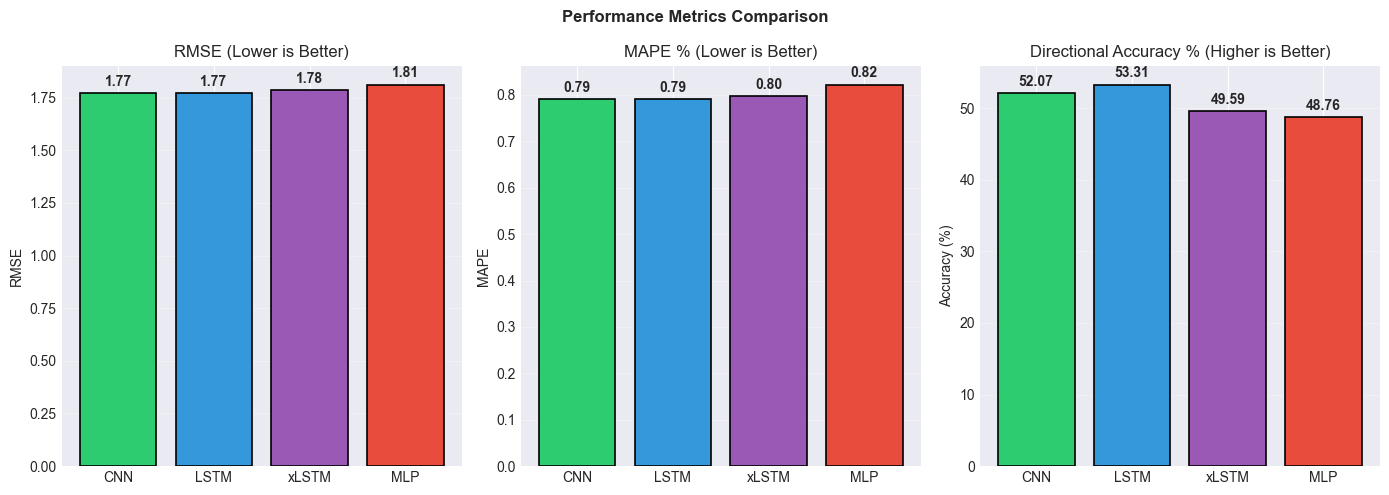

In [10]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Performance Metrics Comparison', fontsize=12, fontweight='bold')

metrics = ['rmse', 'mape', 'dir_accuracy']
titles = ['RMSE (Lower is Better)', 'MAPE % (Lower is Better)', 'Directional Accuracy % (Higher is Better)']
bar_colors = [colors[name] for name in model_names]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    values = [evaluation_results[name][metric] for name in model_names]
    ax = axes[i]
    bars = ax.bar(model_names, values, color=bar_colors, edgecolor='black', linewidth=1.2)
    ax.set_title(title)
    ax.set_ylabel(metric.upper() if metric != 'dir_accuracy' else 'Accuracy (%)')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [11]:
# Final summary
print("\n" + "=" * 70)
print("FINAL SUMMARY: BASELINE MODELS")
print("=" * 70)
print(f"\n{'Model':<10} {'RMSE':>10} {'MAPE (%)':>10} {'Dir.Acc':>10} {'R2':>10}")
print("-" * 70)

best_rmse = min(evaluation_results[n]['rmse'] for n in model_names)
best_mape = min(evaluation_results[n]['mape'] for n in model_names)
best_dir = max(evaluation_results[n]['dir_accuracy'] for n in model_names)

for name in model_names:
    r = evaluation_results[name]
    rmse_mark = '*' if r['rmse'] == best_rmse else ' '
    mape_mark = '*' if r['mape'] == best_mape else ' '
    dir_mark = '*' if r['dir_accuracy'] == best_dir else ' '
    
    print(f"{name:<10} {r['rmse']:>9.4f}{rmse_mark} {r['mape']:>9.4f}{mape_mark} "
          f"{r['dir_accuracy']:>9.2f}{dir_mark} {r['r2']:>10.4f}")

print("-" * 70)
print("* indicates best performance for that metric")
print("=" * 70)
print("\nNote: Compare these results with PatchTST + RevIN model")
print("in stock_prediction_patchtst.ipynb")
print("=" * 70)



FINAL SUMMARY: BASELINE MODELS

Model            RMSE   MAPE (%)    Dir.Acc         R2
----------------------------------------------------------------------
CNN           1.7707*    0.7915      52.07      0.9783
LSTM          1.7729     0.7913*     53.31*     0.9782
xLSTM         1.7841     0.7977      49.59      0.9779
MLP           1.8115     0.8223      48.76      0.9773
----------------------------------------------------------------------
* indicates best performance for that metric

Note: Compare these results with PatchTST + RevIN model
in stock_prediction_patchtst.ipynb
